# Classifier Tester

The goal of this program is to identify the best classifier for each selected sampling method, based on the criteria of minimizing false negatives while still maintaining some effectiveness in identifying true negatives. It allows users to test classifiers on a balanced dataset using cross-validation, or on an unbalanced dataset that includes the false pulsars excluded during the balancing process.

In previous studies found online that address this same task, classifiers were often both trained and tested on the unbalanced HTRU dataset. While these studies reported very high classifier accuracy, the fact that both training and testing were done on highly imbalanced data makes it difficult to determine whether the reported success is effective training or simply a result of **paradoxical accuracy**. To avoid this issue, classifiers in this program are trained on balanced datasets. **The script allows us to examine this effect**, along with the effect of **sampling strategies**.

However, in the context of supporting the astronomical classification of new pulsar candidates, datasets are likely to contain a much larger number of false positives than actual pulsars. Therefore, it's important to evaluate how each classifier—trained on balanced data—performs when tested on a highly unbalanced dataset. This program allows you to choose different ** sampling methods to balance your data and assess their performance ** when combined with various classifiers, using both balanced and unbalanced test sets. The classifiers are meant to function as part of a **human-in-the-loop (HITL) system**, where a human annotator would review the objects classified as pulsars, but not most of those labeled as non-pulsars. Given this setup, **the program prioritizes algorithms with very low false negative rates over those with high overall accuracy**.

In [1]:
# Standard library
from statistics import mean, stdev

# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Preprocessing and metrics
from sklearn import preprocessing, metrics as mt
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Imbalanced-learn: under-sampling
from imblearn.under_sampling import (
    TomekLinks,
    AllKNN,
    RandomUnderSampler,
    NeighbourhoodCleaningRule
)

# Imbalanced-learn: over-sampling
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE


In [2]:
%run Aux_Methods.ipynb

In [3]:
best_results_per_main_run = []

In [4]:
df_0 = pd.read_csv("../data/HTRU_2.csv")

keys = df_0.keys()
class_key = keys[len(keys) - 1]

df_0 = prepare_data(df_0, 0)
df_0.head()

The final dataset contains 17898 samples


,Mean_IP,Standard_Dev_IP,E_Kurtosis_IP,Skewness_IP,Mean_SNR,Standard_Dev_SNR,E_Kurtosis_SNR,Skewness_SNR,Class
0,0.721342,0.417687,0.165043,0.015627,0.013382,0.113681,0.294986,0.063890,0.0
1,0.517628,0.460908,0.235415,0.018268,0.006560,0.072524,0.364015,0.108443,0.0
2,0.520346,0.196868,0.221138,0.040677,0.013030,0.139188,0.288624,0.054610,0.0
3,0.700933,0.437884,0.181750,0.016534,0.015368,0.131583,0.266348,0.046581,0.0
4,0.443854,0.214847,0.249044,0.041712,0.004327,0.039684,0.462029,0.213369,0.0


### Add Classifiers to Evaluate

In [5]:
# Feel free to add classifiers and parameters! :)

classifiers = [
    KNeighborsClassifier,
    svm.SVC,
    LogisticRegression,
    DecisionTreeClassifier,
]

classifiers_names = [
    "KNeighborsClassifier",
    "svm.SVC",
    "LogisticRegression",
    "DecisionTreeClassifier",
]

parameters = [
    ["n_neighbors", range(3, 10)],
    ["kernel", ["linear", "rbf"]],
    ["random_state", range(6, 16, 3)],
    ["criterion", ["gini", "entropy", "log_loss"]],
]

## Performance of Under-Sampler and Classifier Combinations

### Add Undersamplers to Evaluate

In [6]:
# Feel free to add classifiers and parameters! :)

samplers_und = [
    AllKNN(),
    TomekLinks(),
    RandomUnderSampler(random_state=0),
    NeighbourhoodCleaningRule(n_neighbors=4),
]
samplers_names_und = [
    "AllKNN()",
    "TomekLinks()",
    "RandomUnderSampler(random_state=0)",
    "NeighbourhoodCleaningRule(n_neighbors=4)",
]

In [7]:
# Runs and cross vlaidates all combinations of undersamplers and classifiers.
# Evaluates their performance according to the criteria in the flags.
# Displays the confussion matrix of the best performing combination.
# Flag inbalance_testset allows to create an inbalanced testset.


def main_undersample(criteria_flag, flag_im_testset=False):

    total_dict = {}
    if flag_im_testset:
        df = df_0.copy()
    else:
        df = None

    for sampler, name in zip(samplers_und, samplers_names_und):

        dict_sampler = {}
        df_bal = get_balanced_set_undersampling(sampler, df_0.copy(), class_key)

        for classifier_cons, classifier_name, parameter in zip(
            classifiers, classifiers_names, parameters
            ):

            k, v = run_classifier(
                df_bal, classifier_cons, classifier_name, parameter, criteria_flag, df
                )
            dict_sampler[k] = v

        total_dict[min(dict_sampler)] = [dict_sampler[min(dict_sampler)], name]

    #    #Uncomment to see best results per sampler:
    #    print('Best total result for undersampling balancing:')
    #    my_cross_confussion_matrix(total_dict[min(total_dict)][0],total_dict[min(total_dict)][1])

    return total_dict[min(total_dict)][0], total_dict[min(total_dict)][1]


In [8]:
# Flag=0 will score classifiers depending on various criteria.
# Flag=1 will pick the result with the lowest false negative score

criteria_flag=0  

### Performance for Balanced Training and Test Sets

In [9]:
values, sampler_name = main_undersample(criteria_flag, False)
best_results_per_main_run.append([values, sampler_name])

### Best Result

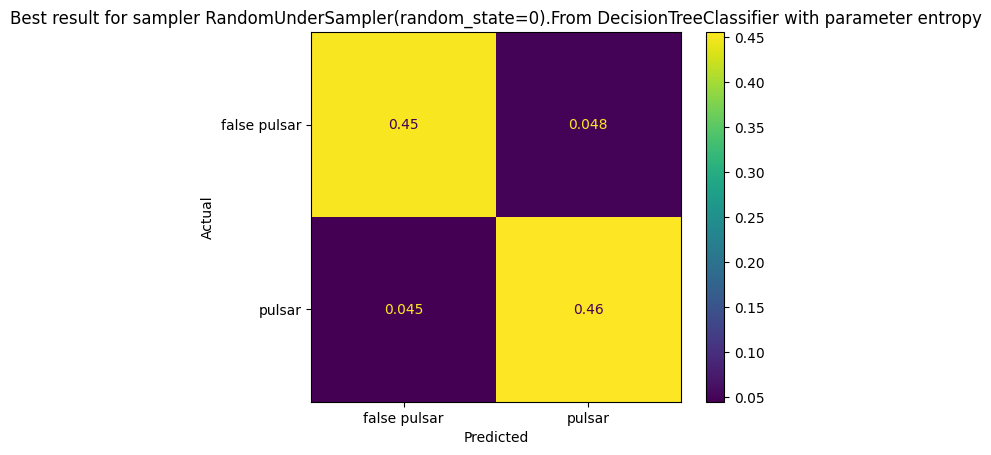

In [10]:
my_cross_confussion_matrix(values, sampler_name)

### Performance for Balanced Training Set and Imbalanced Test Set

In [11]:
values, sampler_name = main_undersample(criteria_flag,True)
best_results_per_main_run.append([values, sampler_name])

### Best Result

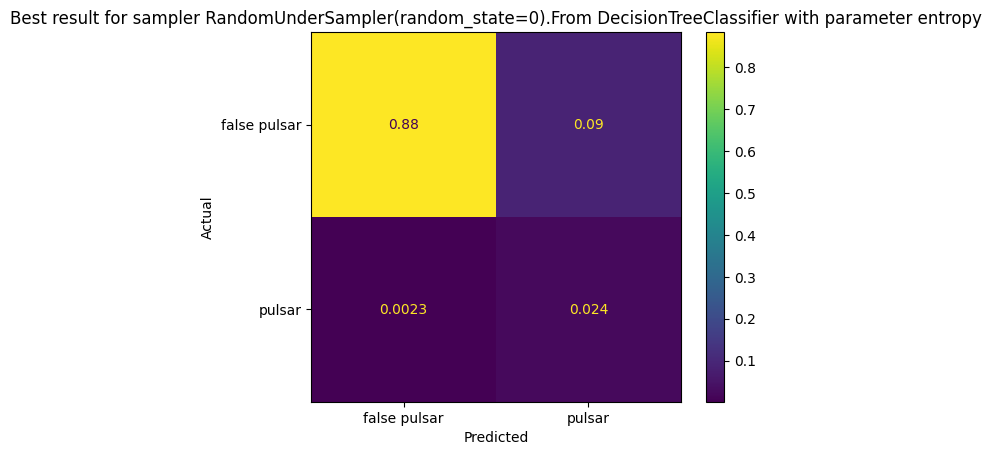

In [12]:
my_cross_confussion_matrix(values, sampler_name)

## Performance of Over-Sampler and Classifier Combinations

### Add Oversamplers to Evaluate

In [13]:
samplers_overs=[ADASYN(),SMOTE(),BorderlineSMOTE()]
samplers_names_overs=['ADASYN()','SMOTE()','BorderlineSMOTE()']

### Performance for Balanced Training Set and Imbalanced Test Set

In [14]:
# Runs and cross validates all combinations of oversamplers and classifiers.
# Evaluates their performance according to the criteria in the flags.
# Displays the confussion matrix of the best performing combination.
# Flag inbalance_testset allows to create an inbalanced testset.


def main_oversample(inbalance_testset=0):

    total_dict = {}

    for sampler, name in zip(samplers_overs, samplers_names_overs):
        dict_sampler = {}
        df_bal = get_balanced_set_oversampling(sampler, df_0.copy(), class_key)

        for classifier_cons, classifier_name, parameter in zip(
            classifiers, classifiers_names, parameters
        ):
            k, v = run_classifier(df_bal, classifier_cons, classifier_name, parameter, criteria_flag)
            dict_sampler[k] = v

        total_dict[min(dict_sampler)] = [dict_sampler[min(dict_sampler)], name]

        print(f"Best result for Sampler {name}:")
        my_cross_confussion_matrix(dict_sampler[min(dict_sampler)], name)

    #    #Uncomment to see best results per sampler:
    print(f'Best total result for undersampling balancing:')
    # my_cross_confussion_matrix(total_dict[min(total_dict)][0],total_dict[min(total_dict)][1])
    
    return total_dict[min(total_dict)][0], total_dict[min(total_dict)][1]


Best result for Sampler ADASYN():


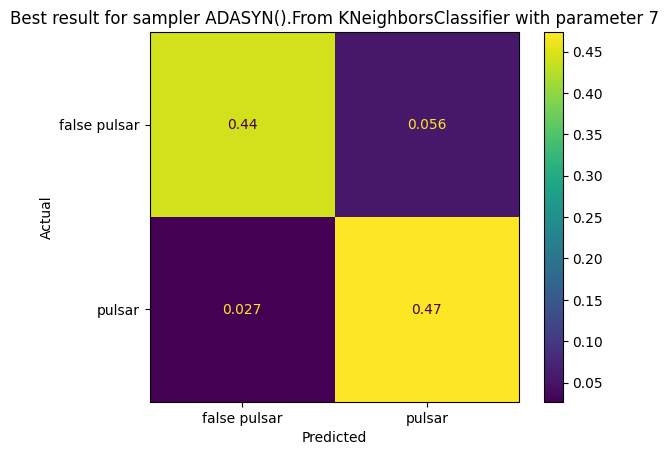

Best result for Sampler SMOTE():


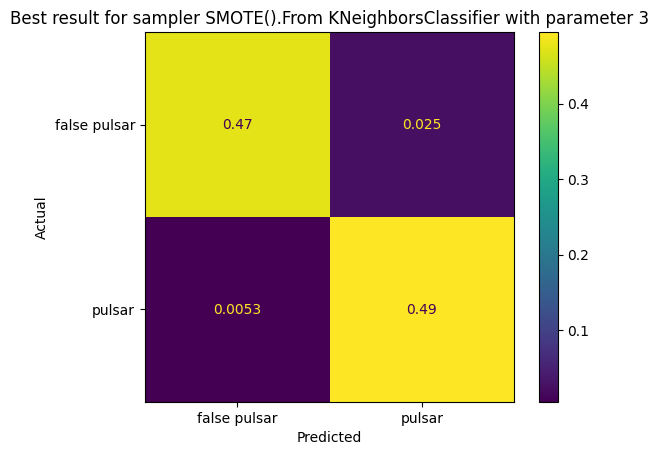

Best result for Sampler BorderlineSMOTE():


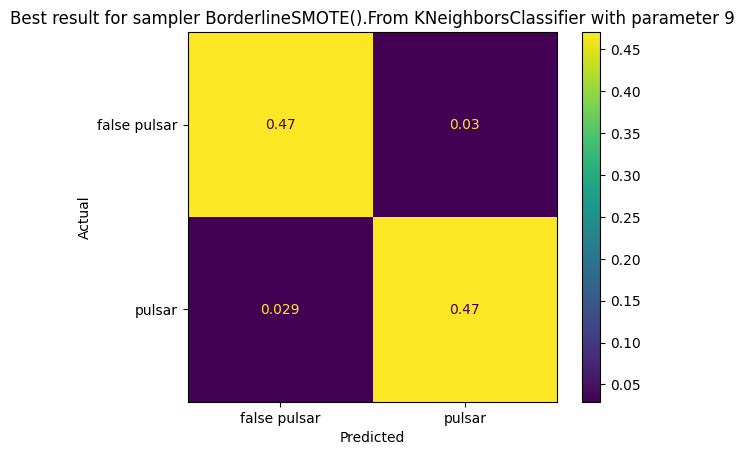

Best total result for undersampling balancing:


In [15]:
values, sampler_name=main_oversample(criteria_flag)
best_results_per_main_run.append([values, sampler_name])

## Sumary

In [16]:
#Displays the best results for each run in a single figure

def sumary():
    case = [
        "Oversampling.",
        "Undersampling. Balanced Test",
        "Undersampling. Imbalanced Test",
    ]

    f, axes = plt.subplots(1, len(best_results_per_main_run), figsize=(20, 10), sharey="row")
    plt.subplots_adjust(top=0.85, bottom=0.01, hspace=0.5, wspace=0.4)
    i = 0
    for n in best_results_per_main_run:

        cm = ConfusionMatrixDisplay(n[0][0], display_labels=["false pulsar", "pulsar"])
        cm.plot(ax=axes[i], xticks_rotation=45)
        t0 = case[i]
        t1 = f"{n[1]}."
        t2 = f" {n[0][1]} withp={n[0][2]} "

        cm.ax_.set(title=t0 + "\n" + t1 + "\n" + t2, xlabel="Predicted", ylabel="Actual")
        cm.im_.colorbar.remove()
        cm.ax_.set_xlabel("")
        i = i + 1

    f.text(0.4, 0.1, "Predicted label", ha="left")
    plt.subplots_adjust(wspace=0.40, hspace=0.1)
    plt.show()


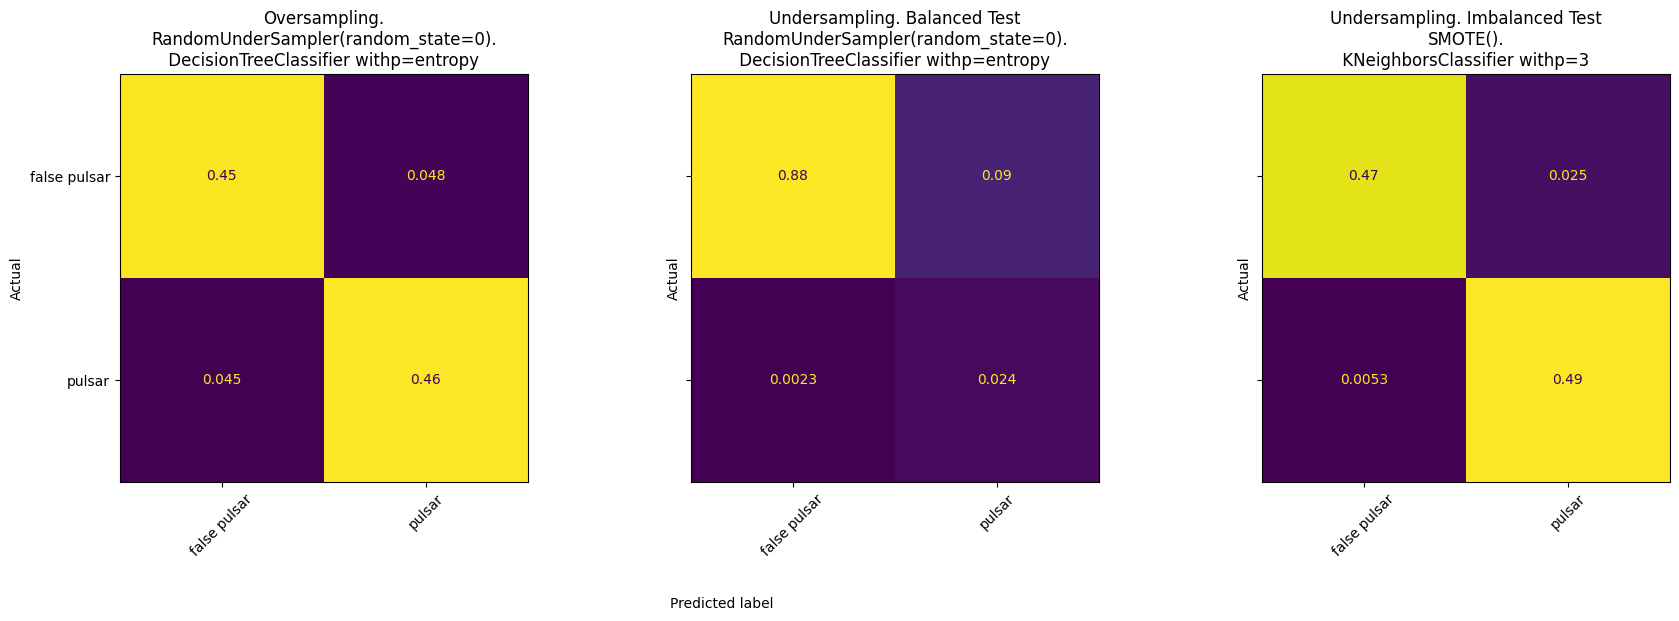

In [17]:
sumary()